In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt


from torchvision.utils import make_grid

In [2]:
torch.manual_seed(1337)

In [12]:
classes=("negative", "positive")

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    "train":
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    "validation":
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

dataset = ImageFolder(root="../images", transform=data_transforms["train"])

In [4]:
splits = [0.8, 0.1, 0.1]
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

In [5]:
split_sizes

[640, 80, 80]

In [6]:
train_set, test_set, val_set = random_split(dataset, split_sizes)

In [7]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=8, shuffle=True),
    "test": DataLoader(test_set, batch_size=8, shuffle=False),
    "val": DataLoader(val_set, batch_size=8, shuffle=False)
}

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [11]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    return model

In [14]:
model_trained = train_model(model, criterion, optimizer, num_epochs=4)

Epoch 1/4
----------
Epoch 2/4
----------
Epoch 3/4
----------
Epoch 4/4
----------


In [15]:
torch.save(model_trained.state_dict(), "../models/weights.pt")

In [17]:
model = models.resnet50().to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load("../models/weights.pt"))

<All keys matched successfully>

In [18]:
test_image_generator = iter(dataloaders["test"])

In [19]:
images, labels = next(test_image_generator)

In [20]:
len(images)

8

In [21]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


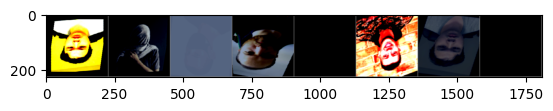

In [22]:
imshow(make_grid(images))

In [23]:
print("GroundTruth: ", ", ".join(f"{classes[labels[j]]:5s}" for j in range(len(images))))

GroundTruth:  positive, negative, negative, positive, positive, positive, positive, negative


In [24]:
pred_labels = model(images.to(device))

In [25]:
pred_labels

tensor([[-3.8147,  3.1312],
        [ 4.8629, -4.8772],
        [ 0.8459, -1.1340],
        [-5.1790,  4.3498],
        [-4.9499,  4.0646],
        [-1.3085,  0.9717],
        [-4.4043,  3.7881],
        [ 6.4644, -6.4728]], grad_fn=<AddmmBackward0>)

In [26]:
pred_probs = F.softmax(pred_labels, dim=1)

In [27]:
pred_probs

tensor([[9.6165e-04, 9.9904e-01],
        [9.9994e-01, 5.8871e-05],
        [8.7868e-01, 1.2132e-01],
        [7.2722e-05, 9.9993e-01],
        [1.2162e-04, 9.9988e-01],
        [9.2772e-02, 9.0723e-01],
        [2.7667e-04, 9.9972e-01],
        [1.0000e+00, 2.4068e-06]], grad_fn=<SoftmaxBackward0>)

In [33]:
images_1, labels_1 = next(test_image_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


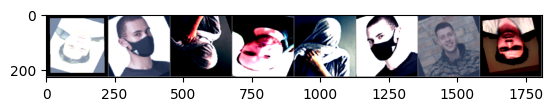

In [34]:
imshow(make_grid(images_1))

In [36]:
print("GroundTruth: ", ", ".join(f"{classes[labels[j]]:5s}" for j in range(len(images_1))))

GroundTruth:  positive, negative, negative, positive, positive, positive, positive, negative


In [37]:
pred_labels_1 = model(images_1.to(device))
pred_probs_1 = F.softmax(pred_labels_1, dim=1)

In [38]:
pred_probs_1

tensor([[8.9321e-03, 9.9107e-01],
        [9.9982e-01, 1.8419e-04],
        [9.9726e-01, 2.7429e-03],
        [1.2177e-03, 9.9878e-01],
        [9.9949e-01, 5.1452e-04],
        [9.9595e-01, 4.0519e-03],
        [5.8126e-05, 9.9994e-01],
        [7.3969e-05, 9.9993e-01]], grad_fn=<SoftmaxBackward0>)

In [39]:
for i, (prob_negative, prob_positive) in enumerate(pred_probs_1.detach().numpy()):
    print(f"Sample {i + 1}: (Negative: {prob_negative:.6f}, Positive: {prob_positive:.6f})")

Sample 1: (Negative: 0.008932, Positive: 0.991068)
Sample 2: (Negative: 0.999816, Positive: 0.000184)
Sample 3: (Negative: 0.997257, Positive: 0.002743)
Sample 4: (Negative: 0.001218, Positive: 0.998782)
Sample 5: (Negative: 0.999485, Positive: 0.000515)
Sample 6: (Negative: 0.995948, Positive: 0.004052)
Sample 7: (Negative: 0.000058, Positive: 0.999942)
Sample 8: (Negative: 0.000074, Positive: 0.999926)
